In [1]:
# doesn't work for some reason
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/ipykernel/.*')

import sys
sys.path.append('../notebooks')
import utils
import os
import numpy as np
import glob
import cv2
import utils
import pylab as pl
import skimage
import shutil
import matplotlib.cm as cm
from sklearn.cross_validation import train_test_split
%matplotlib inline

/home/julien/kaggle/venv/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/home/julien/kaggle/venv/local/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set f

In [2]:
_d = np.load('../data/data_train.npz')
X = _d['X']
Y = _d['Y']

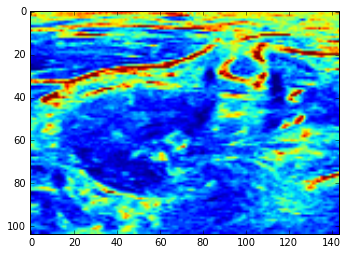

In [3]:
pl.imshow(X[50])

In [4]:
import skimage.transform as sktransf

def rand_float(rng):
    return rng[0] + np.random.random() * (rng[1] - rng[0])

def affine_transform(img, angle_range=None, zoom_range=None, shear_range=None, horiz_shift_range=None,
                     vert_shift_range=None):
    """
    Randomly shift an image by resizing and then random croping the
    resized image
    
    Args:
        img: a (height, width, 2) where [:,:,0] is the grayscale
        image and [:,:,1] the mask
    
    """
    if angle_range is None:
        angle_range = (-10, 10)
    if zoom_range is None:
        zoom_range = (0.9, 1.1)
    if shear_range is None:
        shear_range = (-5, 5) # shear angle in degrees
    if horiz_shift_range is None:
        horiz_shift_range = (-2, 2)
    if vert_shift_range is None:
        vert_shift_range = (-2, 2)
    
    # -- random rotation
    angle = np.deg2rad(rand_float(angle_range))
    zoom = rand_float(zoom_range)
    shear = np.deg2rad(rand_float(shear_range))
    horiz_shift = rand_float(horiz_shift_range)
    vert_shift = rand_float(vert_shift_range)
    
    tform = sktransf.AffineTransform(
        scale=(zoom, zoom),
        rotation=angle,
        shear=shear,
        translation=(horiz_shift, vert_shift)
    )
    M = tform.params
    assert np.allclose(M[2,:], [0, 0, 1])
    #imgt = sktransf.warp(img, tform, order=1, mode='edge')
    imgt = cv2.warpAffine(img, M[:2,:], img.shape[:2][::-1], flags=cv2.INTER_LINEAR,
                               borderMode=cv2.BORDER_CONSTANT)
    return imgt

if False:
    im = np.concatenate((X[0,:,:,None], Y[0,:,:,None]), axis=2)
    imt = affine_transform(im)

    pl.imshow(imt[:,:,0])

In [5]:
# https://www.kaggle.com/bguberfain/ultrasound-nerve-segmentation/elastic-transform-for-data-augmentation/discussion
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

# Function to distort image
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    if False:
        center_square = np.float32(shape_size) // 2
        square_size = min(shape_size) // 3
        pts1 = np.float32([
                center_square + square_size,
                [center_square[0]+square_size, center_square[1]-square_size],
                center_square - square_size
        ])
        pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
        M = cv2.getAffineTransform(pts1, pts2)
        image = cv2.warpAffine(image, M, shape_size[::-1], flags=cv2.INTER_LINEAR,
                               borderMode=cv2.BORDER_REFLECT_101)

    # elastic transform
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

# Define function to draw a grid
def draw_grid(im, grid_size):
    # Draw grid lines
    for i in range(0, im.shape[1], grid_size):
        cv2.line(im, (i, 0), (i, im.shape[0]), color=(1,))
    for j in range(0, im.shape[0], grid_size):
        cv2.line(im, (0, j), (im.shape[1], j), color=(1,))

In [6]:
DATAPATH = '../data/data_clean'
imgs_fnames = [os.path.basename(fname) for fname in glob.glob(DATAPATH + "/*.png") if 'mask' not in fname]

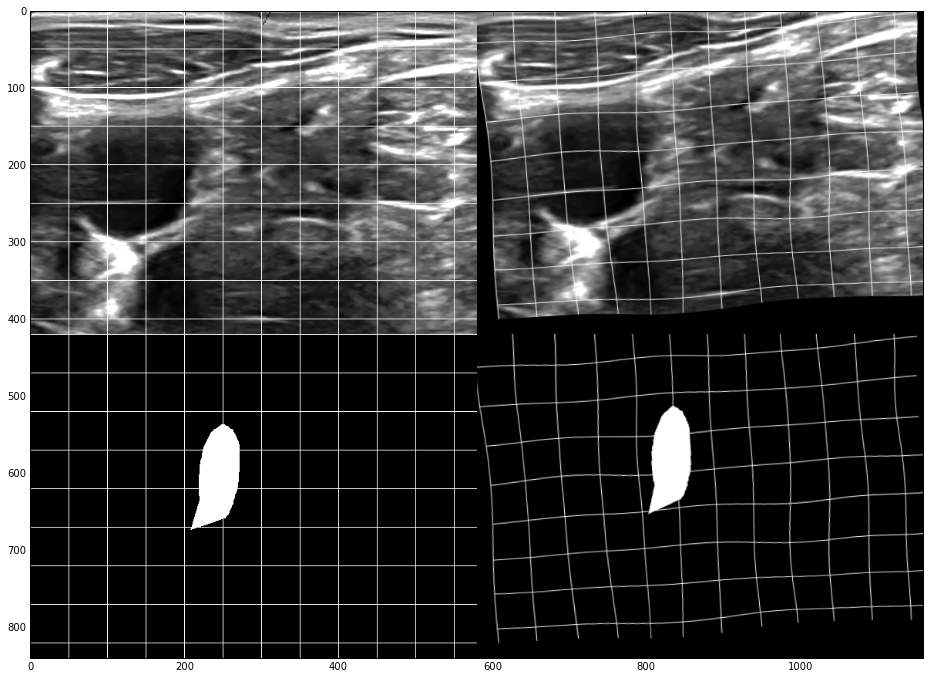

In [7]:
def elastic_distort(im, im_mask, alpha=None, sigma=None, alpha_affine=None, show=False, grid=False):
    if alpha is None:
        alpha = im.shape[1] * 2
    if sigma is None:
        sigma = im.shape[1] * 0.08
    if alpha_affine is None:
        alpha_affine = im.shape[1] * 0.08
        
    if grid:
        im = im.copy()
        draw_grid(im, 50)
        im_mask = im_mask.copy()
        draw_grid(im_mask, 50)
        
    # Merge images into separete channels (shape will be (cols, rols, 2))
    im_merge = np.concatenate((im[:,:,None], im_mask[:,:,None]), axis=2)    
    # Apply transformation on image
    im_merge_t = affine_transform(im_merge)
    im_merge_t = elastic_transform(im_merge_t, alpha, sigma, alpha_affine)

    # Split image and mask
    im_t = im_merge_t[...,0]
    im_mask_t = im_merge_t[...,1]

    if show:
        # Display result
        pl.figure(figsize = (16,14))
        pl.imshow(np.c_[np.r_[im, im_mask], np.r_[im_t, im_mask_t]], cmap='gray')
    return im_t, im_mask_t

def load_and_distort(i, **kwargs):
    img_fname = imgs_fnames[i]
    pnumber, imnumber = os.path.splitext(img_fname)[0].split('_')
    mask_fname = os.path.splitext(img_fname)[0] + "_mask.png"
    img = cv2.imread(os.path.join(DATAPATH, img_fname), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(os.path.join(DATAPATH, mask_fname), cv2.IMREAD_GRAYSCALE)
    
    mask = (mask > 128).astype(np.float32)
    img = img.astype(np.float32) / 255.0
    
    X, Y = elastic_distort(img, mask, **kwargs)
    return X, Y

i = 116
Xt, Yt = load_and_distort(i, show=True, grid=True)

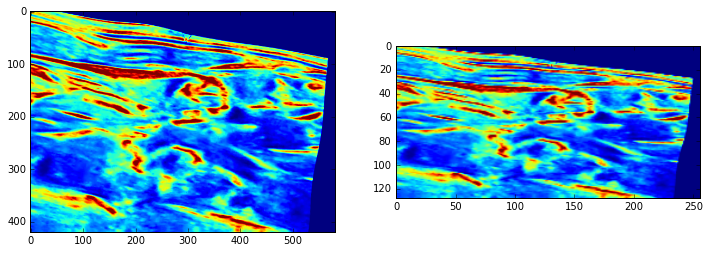

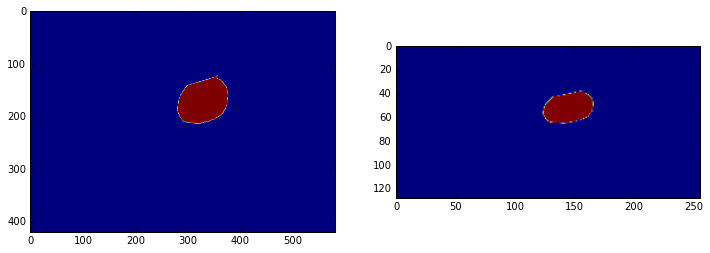

In [8]:
i = 0
#i = 116
Xt, Yt = load_and_distort(i, show=False, grid=False)

newsize = (256, 128)
Xr = cv2.resize(Xt, newsize)
Yr = cv2.resize(Yt, newsize)

pl.figure(figsize=(12, 6))
pl.subplot(121)
pl.imshow(Xt)
pl.subplot(122)
pl.imshow(Xr)

pl.figure(figsize=(12, 6))
pl.subplot(121)
pl.imshow(Yt)
pl.subplot(122)
pl.imshow(Yr)

In [9]:
# 256x128 fp images with image and mask, 5500 training images with 4-times augmented
print '%f GB' % (256 * 128 * 4 * 2 * 5500 * (1 + 4) / (1024. * 1024. * 1024.))

6.713867 GB


In [12]:
OUTDIR = '../data/data_augmented_29'
#utils.mkdir_p(OUTDIR)

N_REPS = 3

newsize = (256, 128)

nimages = len(imgs_fnames) * (N_REPS + 1)
Xt = np.zeros((nimages, 128, 256), dtype=np.float32)
Yt = np.zeros((nimages, 128, 256), dtype=np.float32)

for i in range(len(imgs_fnames)):
    img_fname = imgs_fnames[i]
    pnumber, imnumber = (int(v) for v in os.path.splitext(img_fname)[0].split('_'))
    mask_fname = os.path.splitext(img_fname)[0] + "_mask.png"
    img = cv2.imread(os.path.join(DATAPATH, img_fname), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(os.path.join(DATAPATH, mask_fname), cv2.IMREAD_GRAYSCALE)
    
    mask = (mask > 128).astype(np.float32)
    img = img.astype(np.float32) / 255.0
    
    def save(X, Y, rep):
        X = cv2.resize(X, newsize)
        Y = cv2.resize(Y, newsize)
        Y = Y > 0
        #img_fname = os.path.join(OUTDIR, '%d_%d.%d.png' % (pnumber, imnumber, rep))
        #mask_fname = os.path.join(OUTDIR, '%d_%d.%d_mask.png' % (pnumber, imnumber, rep))
        #cv2.imwrite(img_fname, skimage.img_as_ubyte(X))
        #cv2.imwrite(mask_fname, skimage.img_as_ubyte(Y))
        Xt[i * 4 + rep] = X
        Yt[i * 4 + rep] = Y

    save(img, mask, 0)
    for j in range(N_REPS):
        X, Y = elastic_distort(img, mask)
        save(X, Y, j + 1)
        
    if i % 10 == 0:
        print '\r%d / %d' % (i, len(imgs_fnames)),
        sys.stdout.flush()

3900 / 3906


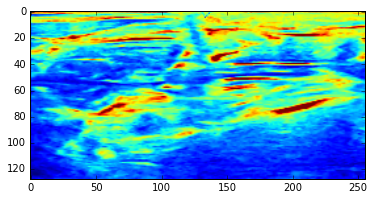

In [20]:
pl.imshow(Xt[10020])

In [22]:
np.savez('../data/data_256_128_clean_elastic_distort.npz', X=Xt, Y=Yt)